# Assignment 2
## ISPR 23/24, third midterm
### by Andrea Marino (matr. 561935)

### Preliminary stuff

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from PIL import Image              # Python Image Library

from typing import List, Tuple

In [2]:
if(colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount("/content/drive")
    BASE_PATH = "drive/MyDrive/ISPR/Compitini ISPR/Terzo Compitino/"
    sys.path.insert(0,BASE_PATH)
    #os.chdir(BASE_PATH)
    #!pip install -U torch           # update PyTorch
    #!pip install -U torchvision     # update torchvision
    !pip install -U optuna           # update optuna
else:
    BASE_PATH = ""


In [3]:
import torch
import torch.nn.functional as F
from torch import nn

#import optuna
import pandas as pd

Let's also set PyTorch's seed to a fixed value, for reproducibility but also to get the same splits in the datasets we're going to create

In [4]:
torch.manual_seed(42)

Finally, we define the device.

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Data and Datasets

Since I already used the dataset for the first assignment, I don't need to download it again. I just have to fetch it from the right directory (in a way that deals with both Colab and my local install)

In [6]:
HORSE_PATH = os.path.join(BASE_PATH,"../Primo Compitino/weizmann_horse_db/horse/")
MASK_PATH = os.path.join(BASE_PATH,"../Primo Compitino/weizmann_horse_db/mask/")

HORSE_PATH, MASK_PATH

('../Primo Compitino/weizmann_horse_db/horse/',
 '../Primo Compitino/weizmann_horse_db/mask/')

We now need to create the class for the dataset, as required by PyTorch.

We can also apply transformations on our data. The principal transformation worth talking about has to deal with the batch size and the shape of the images. 

If in our `DataLoader`s the batch size is set to be greater than 1, then the images have to be of the same shape (height * width), otherwise the associated tensors can't be stacked in a single batch tensor. This is unfortunate, we can deal with it in three ways:
1. Always online learning algorithm (aka batch_size=1)
2. Resize the image
3. Add a padding of zeros to the smaller images, to bring them all to the same size as the bigger image in the dataset (and then let the model deal with the extra padding).

All three options are interesting for their own reasons, so writing a more general code that allows one to apply each of the ideas is worthwhile.

The first option allows to assess the model's performance on images of different sizes, an interesting challenge for sure. The second option is the most promising and most powerful one, as torchvision's tools seems to do a good job at resizing both the images and the mask, upon preliminary checking. The third option is pretty rough, but it might be interesting to see how the model performs in this case.

In [7]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import Lambda

class HorseDataset(Dataset):
    def __init__(self, 
                 image_path=HORSE_PATH,
                 mask_path=MASK_PATH,
                 transform=None, # normalize pixel values
                 target_transform=None,):
        self.img_dir = image_path
        self.mask_dir = mask_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # We know that the answer is 327 but let's make it
        # more general and structured
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path, mask_path = self._horsePath(idx+1)
        img = read_image(img_path)      
        mask = read_image(mask_path)  
        img  = img.float()          # convert to float
        mask = mask.long()          # convert to long
        # transforms given as input
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)
        # standard transforms
        img = img/torch.max(img)    # normalize pixel values
        #mask[mask>0] = 1.0          # set all non-zero values to 1
        return img, mask
    
    def __iter__(self):
        for i in range(len(self)):
            yield self.__getitem__(i)    
    
    def _horsePath(self, h:int):
        '''
        Returns the path to the horse image
        whose number (in the filename) is h
        '''
        number = "0"*(2-int(np.log10(h)))+str(h)
        imgname = "horse" + number + ".png"
        img_path = self.img_dir + imgname
        mask_path = self.mask_dir + imgname
        return img_path, mask_path

To apply the transformations as described, we may need the height and width of the biggest and smallest images in the dataset.

In [8]:
plain_dataset = HorseDataset()

MAX, MIN = (0,0), (np.inf,np.inf)
biggest, smallest = -1,-1

for i, (img, _) in enumerate(plain_dataset,start=1):
    img_h, img_w = tuple(img.shape[1:])
    if img_h*img_w > MAX[0]*MAX[1]:
        MAX = (img_h, img_w)
        biggest = i
    if img_h*img_w < MIN[0]*MIN[1]:
        MIN = (img_h, img_w)
        smallest = i

print(f"The biggest image is horse {biggest}, of size {MAX[0]}x{MAX[1]}")
print(f"The smallest image is horse {smallest}, of size {MIN[0]}x{MIN[1]}")

The biggest image is horse 65, of size 960x1280
The smallest image is horse 16, of size 148x231


We also compute a random permutation that will be used consistently across the three datasets, to split them randomly, but in the same way

In [9]:
from torch.utils.data import Subset

# Compute the sizes of the training and test sets
train_size = int(0.8 * len(plain_dataset))
test_size = len(plain_dataset) - train_size

# Compute the split indices
indices = torch.randperm(len(plain_dataset)).tolist()
train_indices = indices[:train_size]
test_indices = indices[train_size:]

#### Horse dataset of unchanged images

We create a dataset following the first option.

We can use the `random_split` to create the training set and the test set. 

20% of the whole dataset is held out as test set. I chose this approach over cross-validation to alleviate the computational burden.

In [10]:
# Use the pre-computed indices to split the dataset
training_plain_dataset = Subset(plain_dataset, train_indices)
test_plain_dataset = Subset(plain_dataset, test_indices)

The DataLoader will be created later, when they'll be needed.

#### Horse dataset of resized images

Let's see how the `HorseDataset` class allows us to create a dataset of resized images.

In [11]:
from torchvision.transforms import Resize

#resize_transform = lambda h,w: Lambda(lambda X: Resize((h,w))(X))
def resize_transform(height:int, width:int):
    return Lambda(lambda X: Resize((height,width))(X))

# We can resize to the smallest, or choose any other size
h, w = 360, 480

dataset_resized = HorseDataset(transform=resize_transform(h,w), 
                              target_transform=resize_transform(h,w))

train_resized_dataset = Subset(dataset_resized, train_indices)
test_resized_dataset = Subset(dataset_resized, test_indices)

#### Horse dataset of padded images

Lastly, we create a dataset of padded images using the `HorseDataset` class.

Instead of passing a fixed amount of padding to the transformation, we pass it the target height and width of the image.

In [12]:
from torchvision.transforms import Pad

#pad_transform = lambda target_h, target_w: Lambda(lambda X: Pad((X.shape[1]-target_h, X.shape[2]-target_w), fill=0)(X))
def pad_transform(target_h:int, target_w:int):
    return Lambda(lambda X: Pad((target_h-X.shape[1], target_w-X.shape[2]), fill=0)(X))

h, w = MAX

dataset_padded = HorseDataset(transform=pad_transform(h,w), 
                              target_transform=pad_transform(h,w))

train_padded_dataset = Subset(dataset_padded, train_indices)
test_padded_dataset = Subset(dataset_padded, test_indices)

### The model

The task is semantic segmentation of the horse from the background. The chosen model for this task is a *U-shaped network* that uses convolution and transposed convolutions. Given the context, such a network could be referred as a horseshoe network.

Our horseshoe network has two parts: an encoder and a decoder. For the sake of simplicity (and cleanness of code), these are split into two parts.

The architecture I chose is heavily inspired by [SegNet](https://arxiv.org/abs/1511.00561), because it's a network that was designed with the precise purpose of image segmentation, in an efficient way (parameter-wise).

The architecture I propose is modular enough to incorporate some changes, though. For example, a feed-forward layer between the encoder and the decoder can be added.

#### Encoder

Let's start with the `HorseshoeEncoder`. Even though that's somewhat ambiguous and deplorable (the ambiguity is also in the literature), inside a convolutional layer three things will happen:
- A given number of convolutional filters will be applied
- The (batch of) resulting feature maps will be normalized
- An activation function is applied

The `conv_layer` nested function returns a convolutional layer as a `Sequential` container. 

We can specify the structure of our decoder via the `architecture` parameter of the constructor. This parameter is a list of tuple, each tuple being relative to a *block*. 

In this context, a block is just a sequence of convolutional filters followed by a max pooling. More precisely, each tuple in the list specifies how many convolutional layers we want to stack before applying the pooling (1st component of the tuple), and how many convolutional filters there are in each layer inside the block (2nd component of the tuple).

So, in abstract terms, our encoder is just a sequence of blocks. In practice, each block is again a Sequential module, and the encoder's layers are implemented as a `nn.ModuleDict`. A dictionary of modules is used because we need to keep track of the pooling indices of the maximum element. 

In [13]:
class HorseshoeEncoder(nn.Module):
    def __init__(self,
                 architecture:List[Tuple]=[(2,16),(2,32),(3,64),(3,128),(3,128)],
                 in_channels:int=3,) -> None:
        super(HorseshoeEncoder, self).__init__()

        def conv_layer(in_channels, out_channels, *args, **kwargs):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, *args, **kwargs),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        
        self.layers = nn.ModuleDict()

        in_channels = in_channels  # initial number of input channels
        for i, (n_blocks, out_channels) in enumerate(architecture):
            conv_layers = []
            for _ in range(n_blocks):
                conv_layers.append(conv_layer(in_channels, out_channels, kernel_size=3, stride=1, padding=0))
                in_channels = out_channels
            conv_block = nn.Sequential(*conv_layers)
            # We add a MaxPooling layer after the prescribed number of conv layers
            self.layers.add_module(f'conv_block_{i}',nn.ModuleList([conv_block, nn.MaxPool2d(2,2,return_indices=True)]))

        self.conv1x1 = nn.Conv2d(in_channels, 256, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        pooling_indices = []
        input_sizes = []
        #for block in self.layers.values():
        for i in range(len(self.layers)):
            conv_block, pooling_layer = self.layers[f'conv_block_{i}']
            # Apply the convolutional layer
            x = conv_block(x)
            # we need to keep track of the input size
            # before the pooling, to do the unpooling correctly at decoding time
            input_sizes.append(x.size())
            # Apply the pooling layer
            x, indices = pooling_layer(x)
            # We need to keep track of the indices for the unpooling
            pooling_indices.append(indices)
        x = self.conv1x1(x)

        return x, pooling_indices, input_sizes

#### Decoder

The decoder is the mirror image of the encoder. We pass to it the same architecture parameter that was passed to the encoder, and the network is built from right to left in a kind of unintuitive fashion that allows to keep the simmetry and clarity of the code.

In [14]:
class HorseshoeDecoder(nn.Module):
    def __init__(self,
                 architecture:List[Tuple]=[(2,16),(2,32),(3,64),(3,128),(3,128)],
                 out_channels:int=2,) -> None:
        super(HorseshoeDecoder, self).__init__()

        def transp_conv_layer(in_channels, out_channels, *args, **kwargs):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, *args, **kwargs),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        
        self.layers = nn.ModuleDict()

        out_channels = out_channels     # desired n° of output channels
        arch_len = len(architecture)
        for i, (n_blocks, in_channels) in enumerate(architecture):
            transp_conv_layers = []
            for _ in range(n_blocks):
                transp_conv_layers.insert(0,transp_conv_layer(in_channels, out_channels, kernel_size=3, stride=1, padding=0))
                out_channels = in_channels
            transp_conv_block = nn.Sequential(*transp_conv_layers)
            # Since we're building the architecture from right to left, we need to add 
            # (more precisely, index) the modules in reversed order in the dictionary
            self.layers.add_module(f'transp_conv_block_{arch_len-i-1}',nn.ModuleList([nn.MaxUnpool2d(2,2), transp_conv_block])) 

        self.Tconv1x1 = nn.ConvTranspose2d(256, in_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, pooling_indices, input_sizes):
        x = self.Tconv1x1(x)
        #for block in reversed(self.layers.values()):
        for i in range(len(self.layers)):
            unpooling_layer, transp_conv_block = self.layers[f'transp_conv_block_{i}']
            # First the unpooling (which needs the indices used for pooling and the size of the input)...
            x = unpooling_layer(x, pooling_indices.pop(), output_size=input_sizes.pop())
            # ... then the transposed convolution!
            x = transp_conv_block(x)

        return x

#### The full `HorseshoeNetwork`

Since we've separately written the encoder and the decoder, to create our horseshoe network we just have to put them together, basically.

In [15]:
class HorseshoeNetwork(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 out_channels:int=2,
                 architecture:List[Tuple]=[(2,16),(2,32),(3,64),(3,128),(3,128)],):
        super(HorseshoeNetwork, self).__init__()

        # Convolutional layers
        self.encoder = HorseshoeEncoder(architecture=architecture,in_channels=in_channels)

        # Transpose conv. layers
        self.decoder = HorseshoeDecoder(architecture=architecture,out_channels=out_channels)
        
    def forward(self, x):
        # Encoding
        x, pooling_indices, input_sizes = self.encoder(x)

        # Decoding
        x = self.decoder(x, pooling_indices, input_sizes)

        # Final softmax (classification) (not needed for CrossEntropyLoss)
        #x = F.softmax(x, dim=1)
        return x

Unfortunately the transposed convolutional blocks are listed in reversed order in the decoder. 

### Setup for training the model: auxiliary functions

Now that we have the model and the dataset, it's time to write the training cycle.

Following the typical PyTorch's paradygm, let's define a function that performs one cycle of training.

In [16]:
def train(dataloader, model, loss_fn, optimizer) -> None:
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        assert torch.unique(y).tolist() == [0., 1.], f"Error: targets should be in [0, 1] for BCELoss. Instead got: {torch.unique(y).tolist()}, type: {y.dtype}"
        assert X.shape[1] == 3, f"Error: input images should have 3 channels. Instead got: {X.shape[1]}"
        assert torch.max(X) <= 1 and torch.min(X) >= 0, f"Error: input images should be normalized in [0, 1]. Instead got: min {torch.min(X).item()} and max {torch.max(X).item()}"

            ## Forward pass:
        # Compute prediction
        pred = model(X)

        # Compute loss
        # We get rid of the channel dimension in the mask, to compute the loss (it's 1)
        loss = loss_fn(pred, y.squeeze(1))

            ## Backpropagation:
        # Zero out the gradient
        optimizer.zero_grad()
        # Compute the gradient (backward step)
        loss.backward()
        # apply weight update
        optimizer.step()
    

We then need to evaluate the model (aka to test it). That's what the next function does. 

This function can return multiple metrics, but for this assignment only the accuracy will be used.

In [17]:
def compute_score(y_true, 
                  y_pred, 
                  score_fn:str='accuracy') -> float:   
    # turn the probabilities into labels
    # (i.e. get the index of the tensor in which the probability is the highest)
    y_pred_bin = y_pred.argmax(dim=1).float()
    
    y_true = y_true.squeeze(1)

    TPs = (y_true * y_pred_bin).sum().item()
    TNs = ((1 - y_true) * (1 - y_pred_bin)).sum().item()
    FPs = ((1 - y_true) * y_pred_bin).sum().item()
    FNs = (y_true * (1 - y_pred_bin)).sum().item()

    # Since I compute the average, tuurns out the formulas are the ones
    # below
    score = {}
    score['accuracy'] = (TPs + TNs) / (TPs + TNs + FPs + FNs)
    score['precision'] = TPs / (TPs + FPs) if TPs + FPs != 0 else 0
    score['recall'] = TPs / (TPs + FNs) if TPs + FNs != 0 else 0

    if score_fn == 'whole':
        return score
    else:
        return score[score_fn.lower()]

In [18]:
def evaluate(dataloader, model, loss_fn) -> float:
    num_batches = len(dataloader)
    test_loss = 0
    avg_accuracy = 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)

            # compute the loss, and accumulate it
            test_loss += loss_fn(pred, y.squeeze(1)).item()

            # compute accuracy, and accumulate it
            avg_accuracy += compute_score(y_true=y, y_pred=pred, score_fn='accuracy')
    # Average over the number of batches
    avg_accuracy /= num_batches
    test_loss /= num_batches
    return test_loss, avg_accuracy

### Training cycle

Now that we have the auxiliary functions, we're ready to write the training cycle.

#### Dataloaders

We begin by defining which dataset we want to use, among those created with the three strategies.

*For the analysis in this notebook, and the grid search, only the dataset with resized images was used. Individual, localized trials have been performed and the `HorseshoeNetwork` can also handle the non-resized images.*

*Since the non-resized images aren't batched, training on them is significantly slower, since parallelism can't be exploited (this has been verified in exploratory trials). This suggests that the non-resizing approach - though interesting - isn't really viable outside of a small scale.*

In [19]:
dev_dataset = train_resized_dataset
test_dataset = test_resized_dataset

Now we can further split the developement set to hold out the validation set. I choose this approach over K-fold cross validation (which would have been more suitable, given the limited size of the dataset) just because of constraints in terms of computational resources and time.

To recap, 20% of our data is test set, 16% is validation set (20% of 80%) and the remaining 64% is training data.

We finally create the `DataLoaders` that we need.

In [28]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(dev_dataset))
val_size = len(dev_dataset) - train_size

training_dataset, validation_dataset = random_split(dev_dataset, [train_size, val_size])

# Watch out! The non-reshaped images must use batch-size 1
BATCH_SIZE = 10

train_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_dataloader), len(val_dataloader), len(test_dataloader))

21 6 7


#### Grid search

Now it's time for grid searching. Unfortunately, the hyperparameter's list is not very complete, but upon individual trials it was found that the values:
- architecture=`[(2,4),(3,8),(3,16),(3,16)]`
- learning rate = `1e-3`
- weight decay = `1e-5`
yielded good results in as few as 10 epochs (above 70% accuracy in validation).

I would have liked to explore also with a little padding, and with dilated convolutions, but - again - due to constraints in terms of time and computational resources I had to restrict the scope of the analysis.

In particular, the listed architectures are not very big. Neither they're very deep, but the task is binary classification, and the objects shouldn't be too hard to distinguish.

In [21]:
# Define the grid

lr_list = [1e-2, 1e-3, 1e-4]
weight_decay_list = [1e-4, 1e-5, 1e-6]
architectures_list = [
    # small:
    [(2,16),(3,32),(3,64)],
    # medium:
    [(4,8),(3,16),(3,32),(4,64)],
    [(2,16),(3,32),(3,64),(3,64)],
    #[(2,16),(3,32),(3,64),(3,128)],
    # big
    [(2,16),(2,32),(3,64),(3,128),(3,128)],
    [(2,32),(2,64),(3,64),(3,128),(3,128)]  # bigger models don't fit my GPU
]

# patience for early stopping
patience = 5

results_df = pd.DataFrame(columns=['lr', 'weight_decay', 'architecture', 'train_loss_history', 'val_loss_history', 'train_accuracy_history', 'val_accuracy_history', 'epochs', 'best_val_loss'])

In [22]:
from itertools import product

MAX_EPOCHS = 50 # I really don't want to go farther than this...
EARLY_STOPPING = True

for i, (lr, wd, arch) in enumerate(product(lr_list, weight_decay_list, architectures_list), start=1):
    print(f"Search {i} of {len(lr_list)*len(weight_decay_list)*len(architectures_list)}")
    torch.cuda.empty_cache()    # let's try
    model = HorseshoeNetwork(architecture=arch)
    model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    epochs_count = 0
    best_val_loss = float('inf')
    early_stop_count = 0
    val_loss_list, val_accuracy_list = [], []
    train_loss_list, train_accuracy_list = [], []
    for _ in range(MAX_EPOCHS):
        epochs_count += 1
        # Training
        train(train_dataloader, model, loss_fn, optimizer)

        val_loss, val_accuracy = evaluate(test_dataloader, model, loss_fn)
        train_loss, train_accuracy = evaluate(train_dataloader, model, loss_fn)

        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        if EARLY_STOPPING:
            # Check if validation loss has improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stop_count = 0
            else:
                early_stop_count += 1

            # Check if early stopping criterion is met
            if early_stop_count >= patience:
                print("Early stopping...")
                break

    print(f"Training completed after {epochs_count} epochs")
    print(f"Train Error: \n \tAvg loss: {train_loss:>8f}, avg accuracy: {100*train_accuracy:>2.4f}% \n")
    print(f"Validation Error: \n \tAvg loss: {val_loss:>8f}, avg accuracy: {100*val_accuracy:>2.4f}% \n")
    results_df.loc[len(results_df.index)] = [lr, wd, arch, train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list, epochs_count, best_val_loss]

print("Grid search completed!")

Search 1 of 45


/home/andrea/anaconda3/envs/ISPR-env/lib/python3.12/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Early stopping...
Training completed after 21 epochs
Train Error: 
 	Avg loss: 0.348356, avg accuracy: 85.7751% 

Validation Error: 
 	Avg loss: 0.344373, avg accuracy: 86.0559% 

Search 2 of 45


/home/andrea/anaconda3/envs/ISPR-env/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/andrea/anaconda3/envs/ISPR-env/lib/python3.12/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/andrea/anaconda3/envs/ISPR-env/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_

Early stopping...
Training completed after 15 epochs
Train Error: 
 	Avg loss: 0.484242, avg accuracy: 74.5870% 

Validation Error: 
 	Avg loss: 0.479804, avg accuracy: 74.5052% 

Search 3 of 45


/home/andrea/anaconda3/envs/ISPR-env/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/andrea/anaconda3/envs/ISPR-env/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Early stopping...
Training completed after 17 epochs
Train Error: 
 	Avg loss: 0.347133, avg accuracy: 85.9553% 

Validation Error: 
 	Avg loss: 0.325286, avg accuracy: 86.9609% 

Search 4 of 45


/home/andrea/anaconda3/envs/ISPR-env/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/andrea/anaconda3/envs/ISPR-env/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Early stopping...
Training completed after 16 epochs
Train Error: 
 	Avg loss: 0.340312, avg accuracy: 84.7070% 

Validation Error: 
 	Avg loss: 0.328149, avg accuracy: 85.5190% 

Search 5 of 45
Early stopping...
Training completed after 14 epochs
Train Error: 
 	Avg loss: 0.382062, avg accuracy: 85.3874% 

Validation Error: 
 	Avg loss: 0.362633, avg accuracy: 86.4267% 

Search 6 of 45
Early stopping...
Training completed after 27 epochs
Train Error: 
 	Avg loss: 0.344399, avg accuracy: 81.5357% 

Validation Error: 
 	Avg loss: 0.335736, avg accuracy: 81.7945% 

Search 7 of 45
Early stopping...
Training completed after 15 epochs
Train Error: 
 	Avg loss: 0.335356, avg accuracy: 79.5758% 

Validation Error: 
 	Avg loss: 0.327616, avg accuracy: 80.0472% 

Search 8 of 45
Early stopping...
Training completed after 37 epochs
Train Error: 
 	Avg loss: 0.269160, avg accuracy: 89.0902% 

Validation Error: 
 	Avg loss: 0.250767, avg accuracy: 89.8825% 

Search 9 of 45
Training completed after 

In [23]:
# export the results
results_df.to_csv('results.csv', index=False)

### Discussion of the results

*The next cell is only needed in case the dataframe has to be loaded from the .csv file*

In [ ]:
import ast

# In case we have to load the results from the saved ones:
results_df = pd.read_csv('results.csv')

# All this mess because pandas saves lists of floats as strings...
results_df['val_loss_history'] = results_df['val_loss_history'].apply(lambda str: [float(x) for x in str[1:-1].split(', ')])
results_df['train_loss_history'] = results_df['train_loss_history'].apply(lambda str: [float(x) for x in str[1:-1].split(', ')])
results_df['val_accuracy_history'] = results_df['val_accuracy_history'].apply(lambda str: [float(x) for x in str[1:-1].split(', ')])
results_df['train_accuracy_history'] = results_df['train_accuracy_history'].apply(lambda str: [float(x) for x in str[1:-1].split(', ')])

results_df['architecture'] = results_df['architecture'].apply(lambda str: ast.literal_eval(str))

min_val_loss_index = results_df['best_val_loss'].idxmin()
best_row_dict = results_df.loc[min_val_loss_index].to_dict()

#results_df.head()

,lr,weight_decay,architecture,train_loss_history,val_loss_history,train_accuracy_history,val_accuracy_history,epochs,best_val_loss
0,0.01,0.0001,"[(2, 16), (3, 32), (3, 64)]","[0.5814551938147772, 0.5903628723961967, 0.871...","[0.5701585497174945, 0.5820604307310921, 0.899...","[0.7480466820987655, 0.7468428612764549, 0.751...","[0.7582457010582011, 0.7549419918430335, 0.753...",21,0.338118
1,0.01,0.0001,"[(4, 8), (3, 16), (3, 32), (4, 64)]","[0.7585651079813639, 0.5796903570493063, 0.484...","[0.7376037069729396, 0.5846184066363743, 0.480...","[0.6924647128527336, 0.7511854883156966, 0.755...","[0.6944028604497355, 0.7547568066578483, 0.761...",15,0.331357
2,0.01,0.0001,"[(2, 16), (3, 32), (3, 64), (3, 64)]","[1.034183232557206, 0.48095367494083585, 0.481...","[1.0129352722849165, 0.47846589769635883, 0.47...","[0.736697296626984, 0.7730135237544092, 0.7466...","[0.7428383763227513, 0.7770593584656085, 0.757...",17,0.310178
3,0.01,0.0001,"[(2, 16), (2, 32), (3, 64), (3, 128), (3, 128)]","[3.4835580530620756, 0.645168179557437, 0.5124...","[3.884931666510446, 0.6464611462184361, 0.5066...","[0.747106391920194, 0.7278748484347441, 0.7461...","[0.7374151785714286, 0.7232040343915344, 0.754...",16,0.295094
4,0.01,0.0001,"[(2, 32), (2, 64), (3, 64), (3, 128), (3, 128)]","[8.605380875723702, 0.5638817378452846, 0.5674...","[9.110618114471436, 0.557637883084161, 0.56878...","[0.7450646425815697, 0.7475207437720458, 0.832...","[0.7364193397266314, 0.7531372630070547, 0.833...",14,0.309217


In [ ]:
# Get the index of the row with the lowest validation loss
min_val_loss_index = results_df['best_val_loss'].idxmin()

# Get the row with the lowest validation loss
best_row_dict = results_df.loc[min_val_loss_index].to_dict()

{'lr': 0.01, 'weight_decay': 1e-05, 'architecture': [(2, 16), (2, 32), (3, 64), (3, 128), (3, 128)], 'train_loss_history': [5.087042422521682, 0.448248599256788, 0.4038673085825784, 0.3684849086261931, 0.3660209136349814, 0.32551958021663485, 0.3549714358080001, 0.2908322037685485, 0.3094844960031055, 0.277589683731397, 0.3102766616003854, 0.2715000226384118, 0.2899895544563021, 0.25380910010564894, 0.25341672060035525, 0.266844378340812, 0.2569892427750996, 0.284446323911349, 0.2405629718587512, 0.2378538442509515, 0.2606146115632284, 0.29440228924864814, 0.2840023140112559, 0.23066601299104236, 0.2243615481115523, 0.191204153356098, 0.21229922345706395, 0.24965176695869082, 0.2919044210797265, 0.2221728882619313, 0.19937448274521602, 0.20253707397551762, 0.19785291027455104, 0.3040427097252437, 0.22946931989420027, 0.1802946612948463, 0.18159698765902293, 0.1720405284847532, 0.3424606663840158, 0.2999232773269926, 0.18673609480971382, 0.17748461663722992, 0.19543917548088802, 0.21213

In [ ]:
print(f"The best architecture is: {best_row_dict['architecture']}")
print(f"For it, the best learning rate is: {best_row_dict['lr']}, with regularization hyperparameter: {best_row_dict['weight_decay']}")
print(f"Allegedly, it achieved a validation loss of: {best_row_dict['best_val_loss']}")
print(f"Allegedly, it achieved a validation accuracy of: {100*max(best_row_dict['val_accuracy_history']):>2.4f}%")

The best architecture is: [(2, 16), (2, 32), (3, 64), (3, 128), (3, 128)]
For it, the best learning rate is: 0.01, with regularization hyperparameter: 1e-05
Allegedly, it achieved a validation loss of: 0.1542841653738703
Allegedly, it achieved a validation accuracy of: 93.8841%


So, large architectures were favoured. I don't think this is very surprising, but as a term of comparison, let's see how the small architecture performed:

### Plot results

Once the grid search is completed, we can retrieve the best hyperparameters, and plot the learning curve and accuracy.

In [43]:
def save_plot(plot, 
              filename:str,
              folder:str='Images', 
              format:str='png') -> None:
    if not filename.endswith(format):
        filename = filename.split('.')[0] + '.' + format

    fig_path = os.path.join(folder, filename)
    plot.savefig(fig_path, format=format)

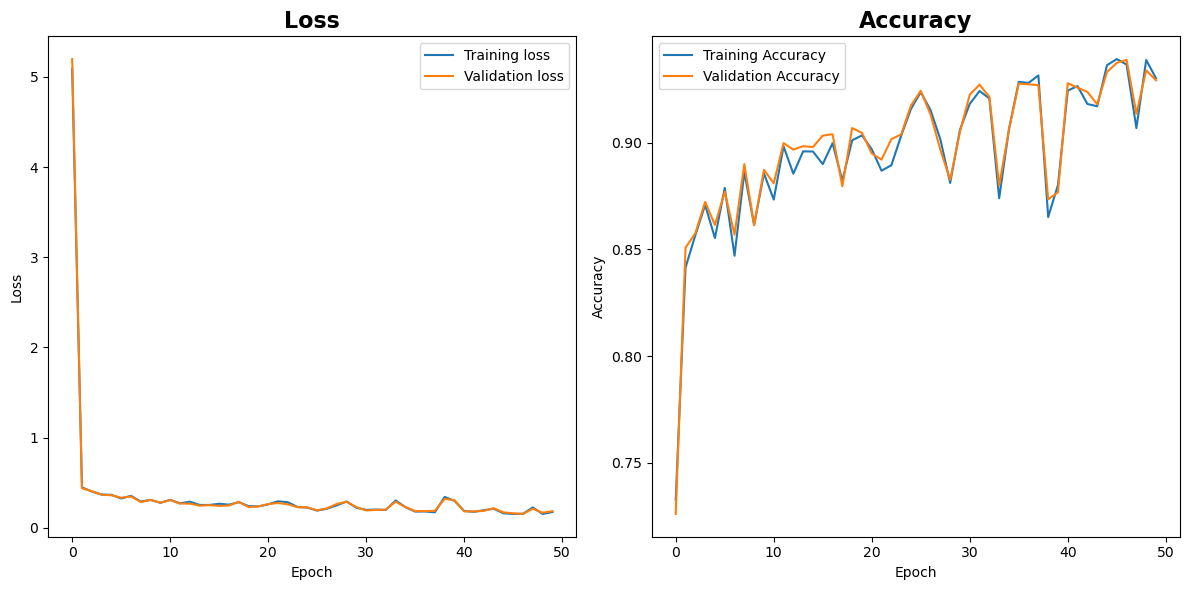

In [51]:
train_loss_list = best_row_dict['train_loss_history']
val_loss_list = best_row_dict['val_loss_history']
train_accuracy_list = best_row_dict['train_accuracy_history']
val_accuracy_list = best_row_dict['val_accuracy_history']

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_loss_list, label='Training loss')
ax[0].plot(val_loss_list, label='Validation loss')
ax[0].set_title('Loss', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_accuracy_list, label='Training Accuracy')
ax[1].plot(val_accuracy_list, label='Validation Accuracy')
ax[1].set_title('Accuracy', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
save_plot(plt, filename='best_model_loss_accuracy')

plt.show()

We can now build a model with the best hyperparameters we found, and re-train it on the whole developement set.

In [53]:
model = HorseshoeNetwork(architecture=best_row_dict['architecture'])
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_row_dict['lr'], weight_decay=best_row_dict['weight_decay'])

In [54]:
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [55]:
dev_loss_list, dev_accuracy_list = [], []
#val_loss_list, val_accuracy_list = [], []

# We aim at the best loss found before early stopping, 
# but we still want to stop after a while...
EPOCHS = 2*best_row_dict['epochs']
best_loss = best_row_dict['best_val_loss']
epsilon = 1e-4

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dev_dataloader, model, loss_fn, optimizer)
    # Compute the loss and accuracy
    loss, acc = evaluate(dev_dataloader, model, loss_fn)

    # print
    print(f"Train Error: \n \tAvg loss: {loss:>8f}, avg accuracy: {100*acc:>2.4f}% \n")
    # Store loss and accuracy for the current epoch
    dev_loss_list.append(loss)
    dev_accuracy_list.append(acc)
    
    if loss <= best_loss + epsilon:
        print("Training halted due to reaching the best loss")
        break
    
print(f"Training completed after {t+1} epochs")

Epoch 1
-------------------------------


/home/andrea/anaconda3/envs/ISPR-env/lib/python3.12/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Train Error: 
 	Avg loss: 0.573569, avg accuracy: 77.1276% 

Epoch 2
-------------------------------
Train Error: 
 	Avg loss: 0.442351, avg accuracy: 78.8013% 

Epoch 3
-------------------------------
Train Error: 
 	Avg loss: 0.439986, avg accuracy: 79.7732% 

Epoch 4
-------------------------------
Train Error: 
 	Avg loss: 0.485283, avg accuracy: 75.0083% 

Epoch 5
-------------------------------
Train Error: 
 	Avg loss: 0.363463, avg accuracy: 78.6925% 

Epoch 6
-------------------------------
Train Error: 
 	Avg loss: 0.321187, avg accuracy: 84.5676% 

Epoch 7
-------------------------------
Train Error: 
 	Avg loss: 0.408838, avg accuracy: 81.9334% 

Epoch 8
-------------------------------
Train Error: 
 	Avg loss: 0.293755, avg accuracy: 87.8034% 

Epoch 9
-------------------------------
Train Error: 
 	Avg loss: 0.294261, avg accuracy: 86.8943% 

Epoch 10
-------------------------------
Train Error: 
 	Avg loss: 0.303508, avg accuracy: 87.6899% 

Epoch 11
--------------------

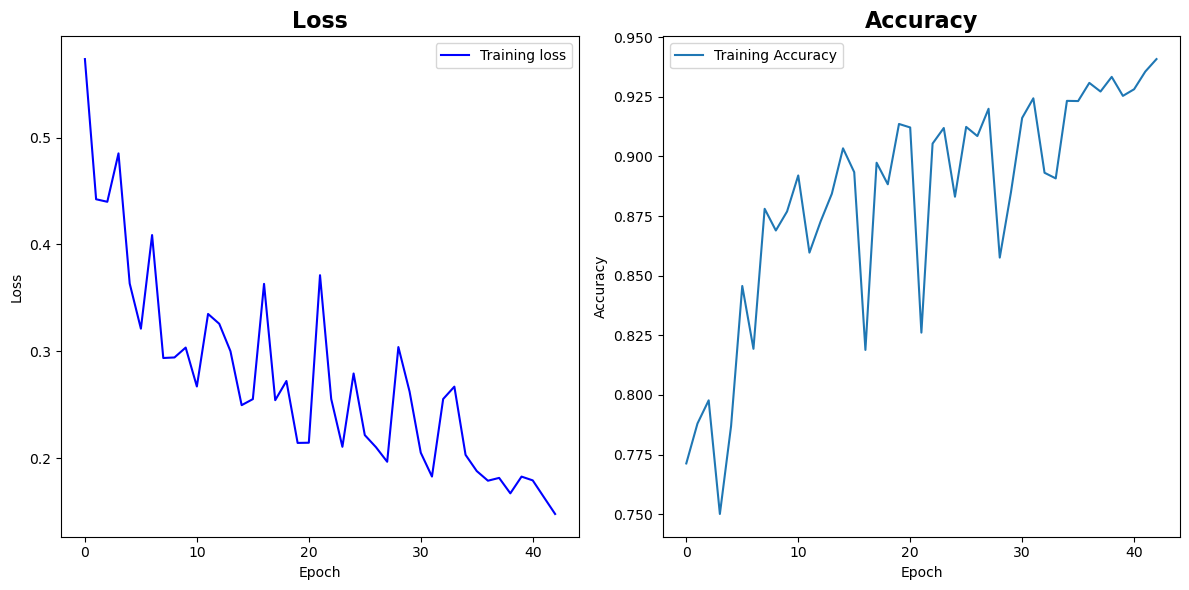

In [56]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(dev_loss_list, label='Training loss', color='blue')
#ax[0].plot(val_loss_list, label='Validation loss', color='red')
ax[0].set_title('Loss', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(dev_accuracy_list, label='Training Accuracy')
#ax[1].plot(val_accuracy_list, label='Validation Accuracy')
ax[1].set_title('Accuracy', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
save_plot(plt, filename='retrained')

plt.show()

In [62]:
print(f"Loss on last epoch: {dev_loss_list[-1]:>8f}")
print(f"Accuracy on last epoch: {100*dev_accuracy_list[-1]:>2.4f}%")

Loss on last epoch: 0.147744
Accuracy on last epoch: 94.0811%


### Test

Overall not a great result, visually speaking. The accuracy score is very good, though.

#### Assess test error

We can evaluate our freshly retrained model on the test set.

In [ ]:
test_loss, test_accuracy = evaluate(test_dataloader, model, loss_fn)

print(f"Test Error: \n \tAvg loss: {test_loss:>8f}, avg accuracy: {100*test_accuracy:>2.4f}% \n")

#### Just a visualization

Let's try on a test image, just to visualize a result

torch.Size([1, 2, 360, 480]) torch.Size([1, 360, 480]) torch.Size([3, 360, 480])


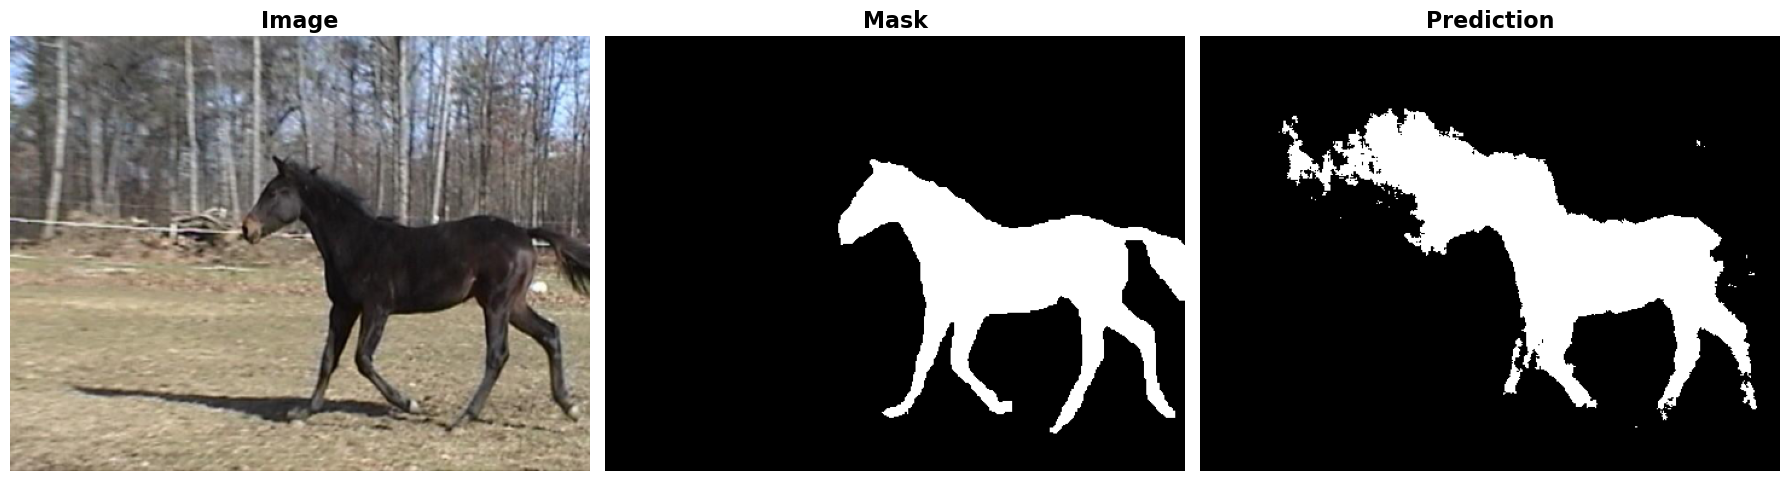

In [ ]:
img, mask = test_resized_dataset[0]
img, mask = img.to(device), mask.to(device)
pred = model(img[None, ...])    # add a batch dimension


pred_bin = pred.argmax(1).float()       # binarize the prediction
pred_bin = pred_bin.squeeze()           # remove the batch dimension and the channel dimension

print(pred.shape, mask.shape, img.shape)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(img.cpu().permute(1, 2, 0))
ax[0].set_title('Image', fontsize=16, fontweight='bold')
ax[0].axis('off')

ax[1].imshow(mask.cpu().squeeze(), cmap='gray')
ax[1].set_title('Mask', fontsize=16, fontweight='bold')
ax[1].axis('off')

ax[2].imshow(pred_bin.cpu().detach(), cmap='gray')
ax[2].set_title('Prediction', fontsize=16, fontweight='bold')
ax[2].axis('off')

plt.tight_layout()
plt.show()

#### Retraining & saving the model

We've selected the model and assessed the validation error. We can retrain on the whole developement set

In [ ]:
whole_data = DataLoader(plain_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = HorseshoeNetwork(architecture=best_row_dict['architecture'])
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_row_dict['lr'], weight_decay=best_row_dict['weight_decay'])

In [ ]:
loss_list, accuracy_list = [], []

# We aim at the best loss found before early stopping, 
# but we still want to stop after a while...
EPOCHS = 2*best_row_dict['epochs']
best_loss = best_row_dict['best_val_loss']
epsilon = 1e-4

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(whole_data, model, loss_fn, optimizer)
    # Compute the loss and accuracy
    loss, acc = evaluate(whole_data, model, loss_fn)

    # print
    print(f"Train Error: \n \tAvg loss: {loss:>8f}, avg accuracy: {100*acc:>2.4f}% \n")
    # Store loss and accuracy for the current epoch
    dev_loss_list.append(loss)
    dev_accuracy_list.append(acc)
    
    if loss <= best_loss + epsilon:
        print("Training halted due to reaching the best loss")
        break
    
print(f"Training completed after {t+1} epochs")

We can save the model trained on the whole data

In [63]:
torch.save(model.state_dict(), 'model.pth')

### Conclusions

We've seen how to do semantic segmentation with an encoder-decoder architecture based on convolutional network, using the `HorseshoeNetwork` proposed in this notebook.

We've seen that the architecture of the encoder is based on *blocks* of *convolutional layers* followed by max pooling layers. The architecture of the decoder mirrors that of the encoder. All in all, the network is versatile, as it can be easily and clairly be defined by a single parameter, and could be extended by adding a feedforward layer between encoder and decoder. 

The `HorseshoeNetwork` could also deal with multi-class classification (i.e. semantic segmentation), and can deal with images of different dimensions.

Unfortunately the scope of the exploration isn't as broad as what I would have liked it to be. Noticeably, these interesting aspects were left out:
- K-fold cross validation for model selection
- Hyperparameter optimization using Optuna (I wrote the code and ran it, hoping to save some time w.r.t. full grid search, but it turned out not to be so...)
- Select among models that used different strategies for building the dataset (padding/resizing/leaving them be), and discuss their performance to tackle the question "what's the best way to feed data to a convolutional network?"
- A further comparison in terms of score could have been made. The assignment explicitely asked for accuracy, so accuracy is what I used. But the `compute_score` function can compute much more, so a score-wise comparison could have been performed

### Bonus: Ettore the dog

**TODO**